# Project Overview
Objective: Predict the After Tax Return on Equity (ROE) of companies based on financial metrics.
Data: Historical financial data of companies listed on the NYSE, including various financial metrics.

## Importing Necessary Libraries
We'll start by importing all the essential libraries required for data manipulation, visualization, and modeling.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

# Model Explainability
import shap
import lime
from lime import lime_tabular

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set plot aesthetics
sns.set_theme(style="whitegrid", palette="muted")
%matplotlib inline

## Loading and Inspecting the Data
We'll load the dataset, inspect the first few rows, check for missing values, and understand the data types.

In [2]:
# Load the dataset with the first column as index
df = pd.read_csv('../data/raw/fundamentals.csv', index_col=0)

# Display the first few rows to inspect the data
print("First five rows of the dataset:")
df.head()

First five rows of the dataset:


,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [3]:
# Check the data types and non-null counts
print("\nData Information:")
df.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 1781 entries, 0 to 1780
Data columns (total 78 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Ticker Symbol                                        1781 non-null   object 
 1   Period Ending                                        1781 non-null   object 
 2   Accounts Payable                                     1781 non-null   float64
 3   Accounts Receivable                                  1781 non-null   float64
 4   Add'l income/expense items                           1781 non-null   float64
 5   After Tax ROE                                        1781 non-null   float64
 6   Capital Expenditures                                 1781 non-null   float64
 7   Capital Surplus                                      1781 non-null   float64
 8   Cash Ratio                                           1

In [4]:
# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Check unique values for columns that may be categorical
print("\nUnique Values per Column:")
print(df.nunique())


Missing Values per Column:
Ticker Symbol                     0
Period Ending                     0
Accounts Payable                  0
Accounts Receivable               0
Add'l income/expense items        0
                               ... 
Total Revenue                     0
Treasury Stock                    0
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
Length: 78, dtype: int64

Unique Values per Column:
Ticker Symbol                    448
Period Ending                    162
Accounts Payable                1676
Accounts Receivable             1329
Add'l income/expense items      1134
                                ... 
Total Revenue                   1757
Treasury Stock                  1015
For Year                           6
Earnings Per Share               744
Estimated Shares Outstanding    1558
Length: 78, dtype: int64


### Sorting and deduplication
We'll ensure that our data splitting respects the chronological order to prevent data leakage. The data splitting into training and testing sets is based on the chronological order of the `Period Ending` column, which ensures that the split is deterministic and consistent.

In [5]:
# Convert 'Period Ending' to datetime
df['Period Ending'] = pd.to_datetime(df['Period Ending'])

# Sort the dataframe by 'Ticker Symbol', 'For Year', and 'Period Ending' to prepare for deduplication
df = df.sort_values(by=['Ticker Symbol', 'For Year', 'Period Ending'])

# Drop duplicates, keeping the last entry for each 'Ticker Symbol' and 'For Year' to handle restatements
df = df.drop_duplicates(subset=['Ticker Symbol', 'For Year'], keep='last')

df.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [6]:
df.nunique()

Ticker Symbol                    448
Period Ending                    157
Accounts Payable                1651
Accounts Receivable             1306
Add'l income/expense items      1115
                                ... 
Total Revenue                   1728
Treasury Stock                  1008
For Year                           6
Earnings Per Share               742
Estimated Shares Outstanding    1552
Length: 78, dtype: int64

In [7]:
pd.crosstab(df['Period Ending'].dt.year, df['For Year'], dropna=False)

For Year,1215.0,2012.0,2013.0,2014.0,2015.0,2016.0,NaN
Period Ending,,,,,,,
2007,0,0,0,0,0,0,1
2012,0,225,0,0,0,0,5
2013,0,18,402,0,0,0,5
2014,0,0,20,398,0,0,6
2015,1,0,0,28,397,0,13
2016,0,0,0,0,28,85,107
2017,0,0,0,0,0,0,1


## Handling Missing Values and filtring
We'll analyze missing data, choose appropriate imputation strategies, and flag missing values.

In [8]:
# Filter the dataframe for the years 2012, 2013, 2014, and 2015
df = df[df['For Year'].isin([2012, 2013, 2014, 2015])]
print("\nFiltered dataset for years 2012-2015:")

# Check the distribution of 'For Year' after filtering
pd.crosstab(df['Period Ending'].dt.year, df['For Year'], dropna=False)


Filtered dataset for years 2012-2015:


For Year,2012.0,2013.0,2014.0,2015.0
Period Ending,,,,
2012,225,0,0,0
2013,18,402,0,0
2014,0,20,398,0
2015,0,0,28,397
2016,0,0,0,28


In [9]:
# identify columns with missing values
df[[c for c in df.columns if df[df[c].isna()].index.size>0]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1516 entries, 0 to 1779
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Cash Ratio                    1248 non-null   float64
 1   Current Ratio                 1248 non-null   float64
 2   Quick Ratio                   1248 non-null   float64
 3   Earnings Per Share            1474 non-null   float64
 4   Estimated Shares Outstanding  1474 non-null   float64
dtypes: float64(5)
memory usage: 71.1 KB


In [10]:
# Identify columns with missing values among the critical financial metrics
critical_cols = ['Cash Ratio', 'Current Ratio', 'Quick Ratio', 'Earnings Per Share', 'Estimated Shares Outstanding']
missing_critical = df[critical_cols].isnull().sum()
print("\nMissing Values in Critical Columns:")
print(missing_critical)

# Drop rows where any of the critical financial metrics are missing
df = df.dropna(subset=critical_cols)
print(f"\nDataset shape after dropping rows with missing critical financial metrics: {df.shape}")

# Ensure that only tickers with complete data across all four years are retained
full_tickers = df.groupby('Ticker Symbol')['For Year'].count() == 4
full_tickers = full_tickers[full_tickers].index
df = df[df['Ticker Symbol'].isin(full_tickers)]
print(f"\nNumber of tickers after ensuring complete data across all years: {len(full_tickers)}")


Missing Values in Critical Columns:
Cash Ratio                      268
Current Ratio                   268
Quick Ratio                     268
Earnings Per Share               42
Estimated Shares Outstanding     42
dtype: int64

Dataset shape after dropping rows with missing critical financial metrics: (1213, 78)

Number of tickers after ensuring complete data across all years: 174


In [11]:
# Drop unnecessary columns
df = df.drop(columns=['Period Ending', 'Pre-Tax ROE'])
print("\nDropped 'Period Ending' and 'Pre-Tax ROE' columns.")

# Display the first few rows after all preprocessing
print("\nFirst five rows after preprocessing:")
df.head()


Dropped 'Period Ending' and 'Pre-Tax ROE' columns.

First five rows after preprocessing:


,Ticker Symbol,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,-260298000.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [12]:
# dataset shape after cleaning
df.nunique()

Ticker Symbol                   174
Accounts Payable                691
Accounts Receivable             570
Add'l income/expense items      540
After Tax ROE                   110
                               ... 
Total Revenue                   695
Treasury Stock                  437
For Year                          4
Earnings Per Share              476
Estimated Shares Outstanding    695
Length: 76, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 0 to 1772
Data columns (total 76 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Ticker Symbol                                        696 non-null    object 
 1   Accounts Payable                                     696 non-null    float64
 2   Accounts Receivable                                  696 non-null    float64
 3   Add'l income/expense items                           696 non-null    float64
 4   After Tax ROE                                        696 non-null    float64
 5   Capital Expenditures                                 696 non-null    float64
 6   Capital Surplus                                      696 non-null    float64
 7   Cash Ratio                                           696 non-null    float64
 8   Cash and Cash Equivalents                            696 non-null    float

## Defining the Target Variable
Define y as Next Year's ROE and Split Data
- shift(-1): Shifts the 'After Tax ROE' column upwards by one, assigning the next year's ROE as the target for the current year's features.

- Exclusion of 2015: Removes the last year since it lacks the subsequent year's ROE, preventing NaN values in the target.

In [14]:
# Define target variable as the next year's After Tax ROE
df['y'] = df.groupby('Ticker Symbol')['After Tax ROE'].shift(-1)

# Exclude the last year (2015) as it doesn't have a following year's ROE
df = df[df['For Year'] != 2015]

print("\nDefined target variable 'y' as next year's After Tax ROE:")
df[['Ticker Symbol', 'For Year', 'After Tax ROE', 'y']].head(10)


Defined target variable 'y' as next year's After Tax ROE:


,Ticker Symbol,For Year,After Tax ROE,y
0,AAL,2012.0,23.0,67.0
1,AAL,2013.0,67.0,143.0
2,AAL,2014.0,143.0,135.0
4,AAP,2012.0,32.0,26.0
5,AAP,2013.0,26.0,25.0
6,AAP,2014.0,25.0,19.0
20,ABT,2012.0,22.0,10.0
21,ABT,2013.0,10.0,11.0
22,ABT,2014.0,11.0,21.0
36,ADS,2012.0,80.0,58.0


### Splitting Data into Training and Testing Sets Based on Time
- Training Set: Includes data from 2012 and 2013.

- Testing Set: Includes data from 2014.

- Dropping Columns: Removes 'Ticker Symbol', 'For Year', and 'y' from feature sets as they're either identifiers or the target variable.

In [15]:
# Split the data into training (2012-2013) and testing (2014) sets
X_train = df[df['For Year'].isin([2012, 2013])].drop(columns=['Ticker Symbol', 'For Year', 'y'])
X_test = df[df['For Year'] == 2014].drop(columns=['Ticker Symbol', 'For Year', 'y'])
y_train = df.loc[df['For Year'].isin([2012, 2013]), 'y']
y_test = df.loc[df['For Year'] == 2014, 'y']

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (348, 74)
Testing set size: (174, 74)


## Exploratory Data Analysis (EDA)

### Univariate Analysis for Numerical Columns
We'll explore the distribution of key numerical features and the target variable (ROE).

In [ ]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('After Tax ROE')  # Exclude target variable

# Plot histograms for selected numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols[:10], 1):  # Plot first 10 for brevity
    plt.subplot(5, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Distribution of the Target Variable (After Tax ROE)
Understanding the distribution of ROE is crucial for modeling.

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['After Tax ROE'], kde=True, bins=30, color='green')
plt.title('Distribution of After Tax ROE')
plt.xlabel('After Tax ROE')
plt.ylabel('Frequency')
plt.show()

### Box Plots to Identify Outliers
Visualizing potential outliers in key features.

In [ ]:
# Plot boxplots for selected numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols[:10], 1):  # Plot first 10 for brevity
    plt.subplot(5, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### Correlation Heatmap
Visualizing the correlation between features and ROE.

In [ ]:
# Compute the correlation matrix
corr_matrix = df[numerical_cols + ['After Tax ROE']].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Pairplot for Selected Features
A pairplot to visualize relationships between a subset of features.

In [ ]:
# Select a subset of features for pairplot
selected_features = ['Accounts Payable', 'Accounts Receivable', 
                     "Add'l income/expense items", 'Capital Expenditures', 
                     'Capital Surplus', 'Cash Ratio', 'After Tax ROE']

sns.pairplot(df[selected_features].dropna(), diag_kind='kde')
plt.suptitle('Pairplot of Selected Financial Metrics', y=1.02)
plt.show()

## Feature Engineering
We'll create additional features that might capture more information, such as financial ratios.

In [ ]:

# # Create financial ratios
# df['Current Ratio'] = df['Total Current Assets'] / df['Total Current Liabilities']
# df['Debt to Equity'] = df['Total Liabilities'] / df['Total Equity']
# df['Net Profit Margin'] = df['Net Income'] / df['Total Revenue']

# # Handle infinite values resulting from division by zero
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Impute newly created ratio columns if any missing values exist
# ratio_cols = ['Current Ratio', 'Debt to Equity', 'Net Profit Margin']
# imputer.fit(df[ratio_cols])
# df[ratio_cols] = imputer.transform(df[ratio_cols])

# print("\nFeature engineering completed with new financial ratios.")

############# 
    

### Visualizing New Financial Ratios
Understanding the distribution of newly created features.

In [ ]:
# Plot histograms for new financial ratios
plt.figure(figsize=(15, 5))
for i, col in enumerate(ratio_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## Encoding Categorical Variables
We'll encode categorical variables using One-Hot Encoding.

In [17]:
# Identify categorical columns in X_train
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_cols:
    # Initialize OneHotEncoder
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    
    # Fit the encoder on X_train
    encoder.fit(X_train[categorical_cols])
    
    # Transform X_train and X_test
    encoded_train = encoder.transform(X_train[categorical_cols])
    encoded_test = encoder.transform(X_test[categorical_cols])
    
    # Get the new column names from the encoder
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    
    # Create DataFrames for encoded features
    encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_cols, index=X_train.index)
    encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_cols, index=X_test.index)
    
    # Concatenate with original feature sets
    X_train = pd.concat([X_train.drop(columns=categorical_cols), encoded_train_df], axis=1)
    X_test = pd.concat([X_test.drop(columns=categorical_cols), encoded_test_df], axis=1)
    
    print("\nCategorical variables encoded using One-Hot Encoding.")
else:
    print("\nNo categorical variables to encode in X_train and X_test.")



No categorical variables to encode in X_train and X_test.


## Scaling Features
We'll scale numerical features to ensure that they contribute equally to the model performance.

In [18]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on X_train and transform both X_train and X_test
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames with original column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nNumerical features scaled using StandardScaler on training and testing sets.")


Numerical features scaled using StandardScaler on training and testing sets.


## Feature Selection and Dimensionality Reduction
We'll select the most relevant features using correlation analysis and regularization techniques. `Pre-Tax ROE` is excluded to prevent data leakage, and `After-Tax ROE` of the current year!

In [40]:
# Remove 'After Tax ROE' from X_train and X_test if present
features_to_remove = ['After Tax ROE']

for feature in features_to_remove:
    if feature in X_train.columns:
        X_train = X_train.drop(columns=[feature])
        print(f"\nDropped '{feature}' from X_train.")
    if feature in X_test.columns:
        X_test = X_test.drop(columns=[feature])
        print(f"Dropped '{feature}' from X_test.")


Dropped 'After Tax ROE' from X_train.
Dropped 'After Tax ROE' from X_test.


### Correlation Analysis to Select Top Features
Identify features that are most correlated with ROE.

In [41]:
# perform feature selection on the training set only to prevent data leakage

# Compute correlation matrix on training set
corr_matrix_train = pd.concat([X_train, y_train], axis=1).corr()

# Get absolute correlation of features with target variable 'y', excluding 'y' itself
correlation_with_roe = corr_matrix_train['y'].abs().sort_values(ascending=False)
correlation_with_roe = correlation_with_roe.drop(['y'])  # Drop target variable

# Display top 10 correlated features
top_features = correlation_with_roe.head(20).index.tolist()  # Top 20 features based on training data
print("\nTop 20 features based on correlation with After Tax ROE:")
print(top_features)


Top 20 features based on correlation with After Tax ROE:
['Cash Ratio', 'Total Equity', 'Capital Surplus', 'Other Assets', 'Deferred Liability Charges', 'Total Assets', 'Total Liabilities & Equity', 'Fixed Assets', 'Non-Recurring Items', 'Net Cash Flows-Investing', 'Other Current Assets', 'Net Receivables', 'Goodwill', 'Depreciation', 'Other Operating Items', 'Short-Term Debt / Current Portion of Long-Term Debt', 'Estimated Shares Outstanding', 'Operating Margin', 'Capital Expenditures', 'Inventory']


### Visualizing Correlation with ROE
Bar plot of top correlated features.

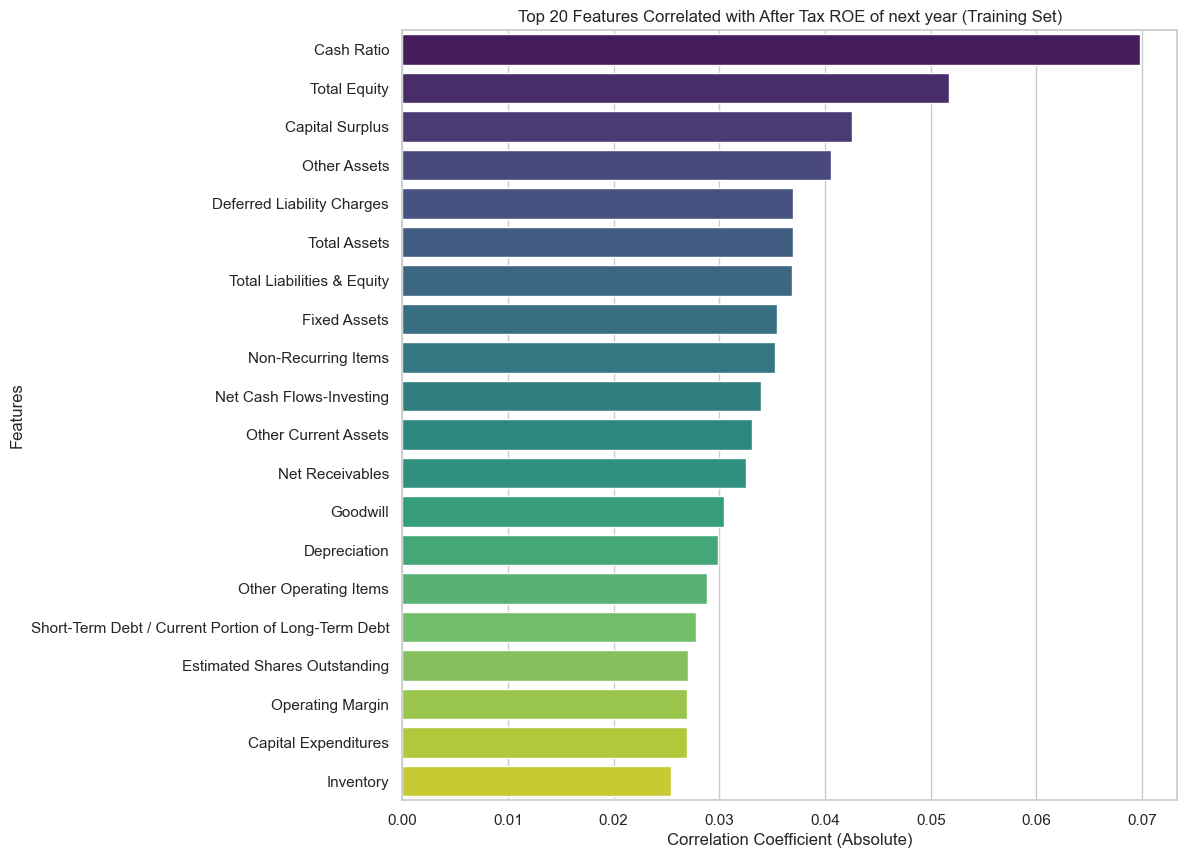

In [42]:
# Plot correlation of top features with ROE based on training data
plt.figure(figsize=(10, 10))
sns.barplot(x=correlation_with_roe[top_features], y=top_features, palette='viridis')
plt.title('Top 20 Features Correlated with After Tax ROE of next year (Training Set)')
plt.xlabel('Correlation Coefficient (Absolute)')
plt.ylabel('Features')
plt.show()

### Feature Importance using Lasso Regression
Using Lasso to perform feature selection.

In [43]:
# Feature Importance using Lasso Regression on the training set
selected_features = top_features.copy()

# Initialize Lasso regression with a small alpha for regularization
lasso = Lasso(alpha=0.01)

# Fit Lasso model on the top correlated features in the training set
lasso.fit(X_train[top_features], y_train)

# Get coefficients from the Lasso model
coef = pd.Series(lasso.coef_, index=top_features)

# Select features with non-zero coefficients
selected_features = coef[coef != 0].index.tolist()
print("\nFeatures selected by Lasso Regression:")
print(selected_features)


Features selected by Lasso Regression:
['Cash Ratio', 'Total Equity', 'Capital Surplus', 'Other Assets', 'Deferred Liability Charges', 'Total Assets', 'Total Liabilities & Equity', 'Fixed Assets', 'Non-Recurring Items', 'Net Cash Flows-Investing', 'Other Current Assets', 'Net Receivables', 'Goodwill', 'Depreciation', 'Other Operating Items', 'Short-Term Debt / Current Portion of Long-Term Debt', 'Estimated Shares Outstanding', 'Operating Margin', 'Capital Expenditures', 'Inventory']


In [44]:
selected_features

['Cash Ratio',
 'Total Equity',
 'Capital Surplus',
 'Other Assets',
 'Deferred Liability Charges',
 'Total Assets',
 'Total Liabilities & Equity',
 'Fixed Assets',
 'Non-Recurring Items',
 'Net Cash Flows-Investing',
 'Other Current Assets',
 'Net Receivables',
 'Goodwill',
 'Depreciation',
 'Other Operating Items',
 'Short-Term Debt / Current Portion of Long-Term Debt',
 'Estimated Shares Outstanding',
 'Operating Margin',
 'Capital Expenditures',
 'Inventory']

### Visualizing Lasso Coefficients
Bar plot of Lasso coefficients.

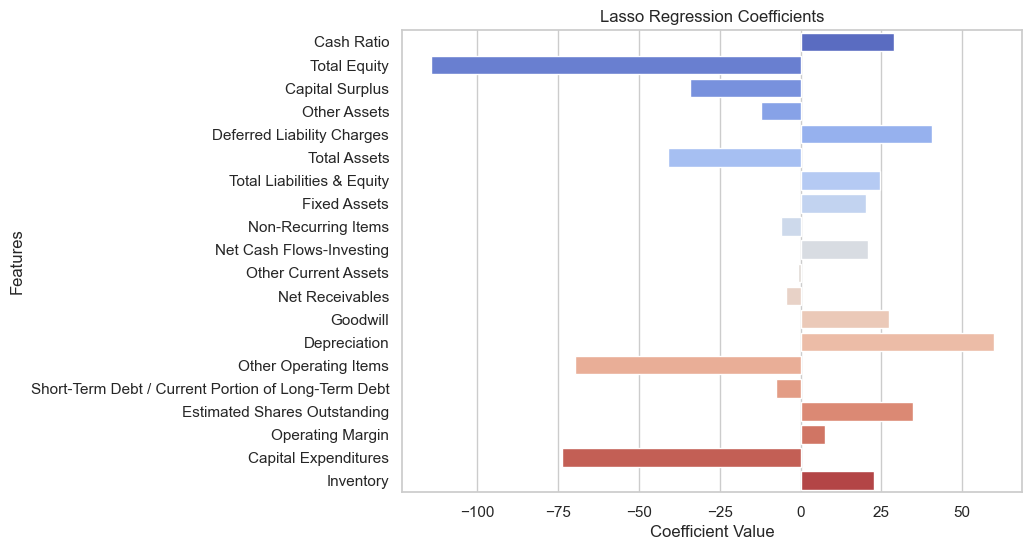

In [45]:
# Plot Lasso coefficients for the selected features
plt.figure(figsize=(8, 6))
sns.barplot(x=coef[selected_features], y=selected_features, palette='coolwarm')
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

## Model Training and Hyperparameter Tuning
We'll train multiple regression models and perform hyperparameter tuning to find the best model.

In [47]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Define hyperparameters for tuning
param_grids = {
    'Ridge Regression': {'alpha': [0.1, 1, 10, 100]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
}

# Dictionary to store best models
best_models = {}

In [48]:
# Filter X_train and X_test to include only the selected features
X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

# Train and tune models using X_train_filtered and y_train
for name, model in models.items():
    print(f"\nTraining {name}...")
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train_filtered, y_train)
        best_models[name] = grid.best_estimator_
        print(f"Best parameters for {name}: {grid.best_params_}")
    else:
        model.fit(X_train_filtered, y_train)
        best_models[name] = model
        print(f"{name} trained without hyperparameter tuning.")


Training Linear Regression...
Linear Regression trained without hyperparameter tuning.

Training Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 100}

Training Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 10}

Training Random Forest...


/Users/mehran/miniforge3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e+07, tolerance: 4.010e+03
  model = cd_fast.enet_coordinate_descent(
/Users/mehran/miniforge3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e+07, tolerance: 3.996e+03
  model = cd_fast.enet_coordinate_descent(
/Users/mehran/miniforge3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}

Training Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Train and tune models using X_train and y_train (all features)
for name, model in models.items():
    print(f"\nTraining {name}...")
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        print(f"Best parameters for {name}: {grid.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[name] = model
        print(f"{name} trained without hyperparameter tuning.")


Training Linear Regression...
Linear Regression trained without hyperparameter tuning.

Training Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 100}

Training Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 10}

Training Random Forest...


/Users/mehran/miniforge3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e+07, tolerance: 4.008e+03
  model = cd_fast.enet_coordinate_descent(
/Users/mehran/miniforge3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e+07, tolerance: 4.010e+03
  model = cd_fast.enet_coordinate_descent(
/Users/mehran/miniforge3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}

Training Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


## Model Evaluation and Explainability
We'll evaluate the performance of each model and interpret feature importance.


Model Evaluation Metrics on Test Set:
               Model        MAE           MSE        RMSE        R2
0  Linear Regression  57.089567  12313.155513  110.964659 -0.125501
1   Ridge Regression  53.424312  11326.450527  106.425798 -0.035310
2   Lasso Regression  53.086674  11175.280768  105.713201 -0.021492
3      Random Forest  51.071087  37294.585790  193.118062 -2.408962
4  Gradient Boosting  51.879146  46421.339305  215.456119 -3.243205


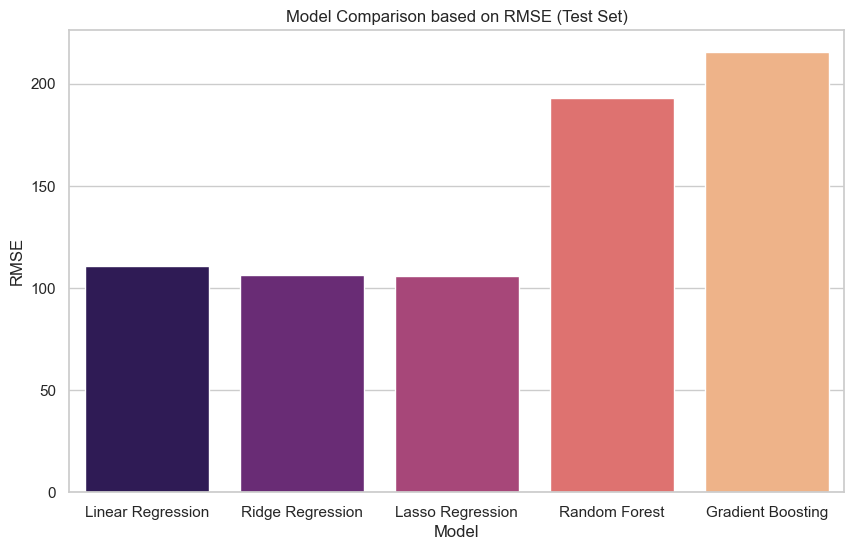

In [49]:
# Initialize a DataFrame to store evaluation metrics
evaluation_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

# Evaluate each model on the testing set
rows = []  # Use a list to collect rows
for name, model in best_models.items():
    y_pred = model.predict(X_test_filtered) # change the test features
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    rows.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

# Convert list of rows to DataFrame
evaluation_metrics = pd.DataFrame(rows)

print("\nModel Evaluation Metrics on Test Set:")
print(evaluation_metrics)

# Plot evaluation metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=evaluation_metrics, palette='magma')
plt.title('Model Comparison based on RMSE (Test Set)')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

### Feature Importance for Tree-Based Models
Visualizing feature importance for Random Forest and Gradient Boosting models.

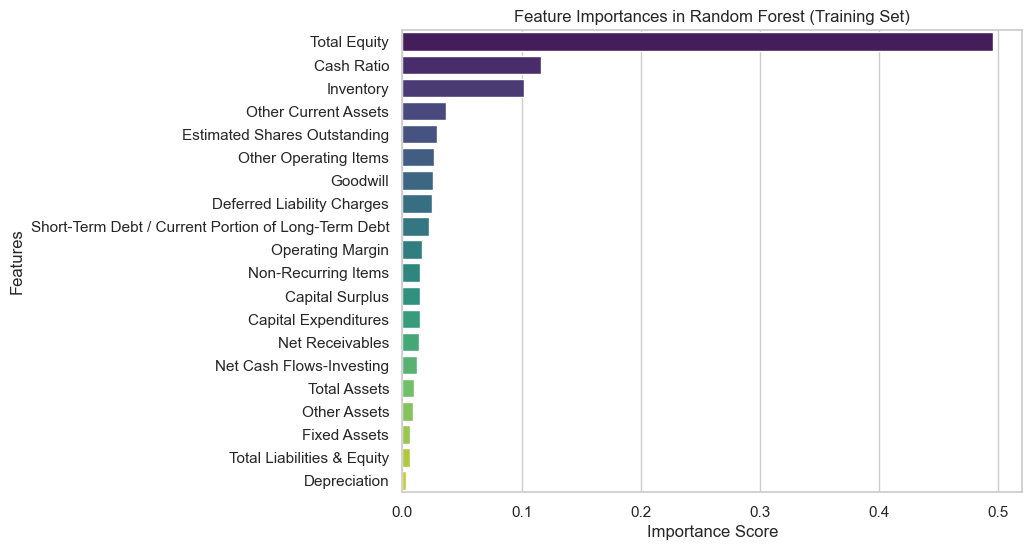

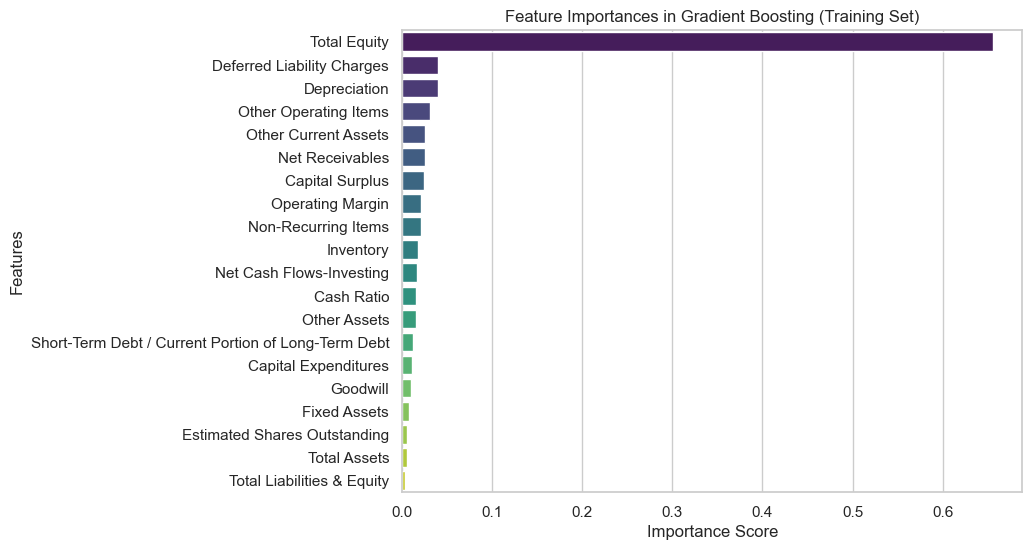

In [52]:
# Feature Importance for Random Forest and Gradient Boosting using X_train and selected_features
for name in ['Random Forest', 'Gradient Boosting']:
    model = best_models[name]
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=selected_features)
        importances = importances.sort_values(ascending=False)
        
        plt.figure(figsize=(8, 6))
        sns.barplot(x=importances.values, y=importances.index, palette='viridis')
        plt.title(f'Feature Importances in {name} (Training Set)')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.show()

### Residual Analysis
Checking residuals to validate model assumptions.

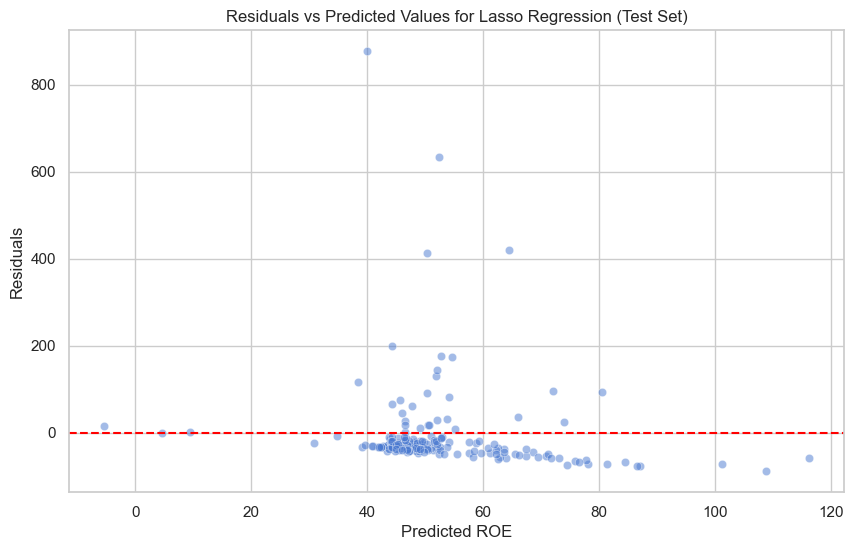

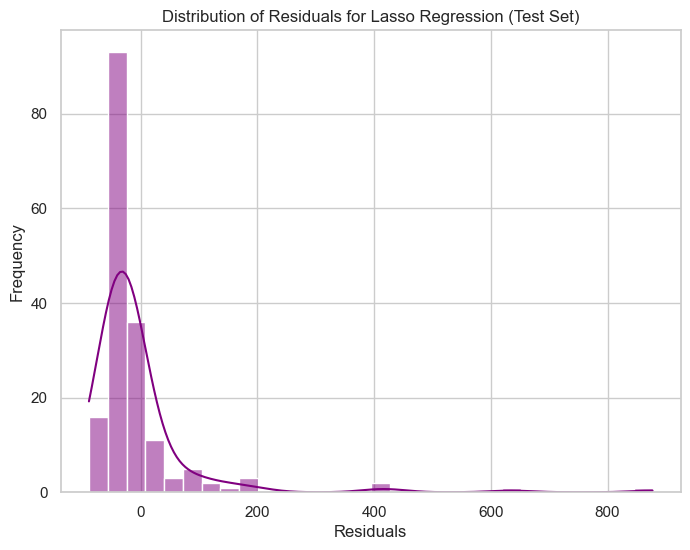

In [55]:
# Plot residuals for the best model based on R2 on the testing set
best_model_name = evaluation_metrics.sort_values(by='R2', ascending=False).iloc[0]['Model']
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test_filtered)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals vs Predicted Values for {best_model_name} (Test Set)')
plt.xlabel('Predicted ROE')
plt.ylabel('Residuals')
plt.show()

# Distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title(f'Distribution of Residuals for {best_model_name} (Test Set)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Model Validation
We'll perform cross-validation to ensure that our models generalize well to unseen data.


Cross-validating Linear Regression...

Cross-validating Ridge Regression...

Cross-validating Lasso Regression...

Cross-validating Random Forest...

Cross-validating Gradient Boosting...

Cross-Validation Metrics:
               Model        MAE            MSE        RMSE        R2
0  Linear Regression  96.543752  160827.662176  345.756041 -0.593357
1   Ridge Regression  69.517532  154208.518501  323.688276 -0.021225
2   Lasso Regression  66.527174  154400.312923  323.453257 -0.007816
3      Random Forest  73.169423  204684.929808  423.991136 -2.970377
4  Gradient Boosting  82.015344  235052.948965  443.217640 -2.169147


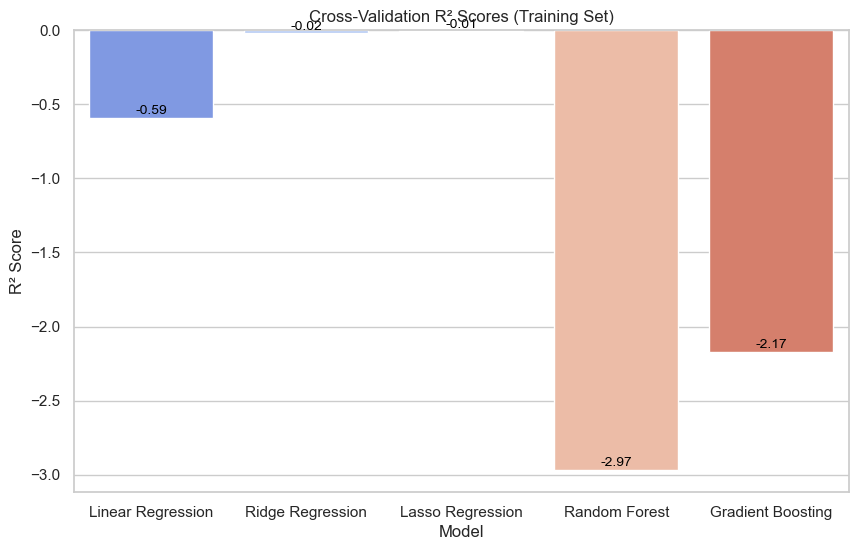

In [59]:
# Initialize TimeSeriesSplit with 3 splits due to smaller training set
tscv = TimeSeriesSplit(n_splits=3)

# Function to perform cross-validation and return average metrics
def cross_validate_model(model, X, y, splits):
    mae_scores = []
    mse_scores = []
    r2_scores = []
    for train_index, test_index in splits.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        mae_scores.append(mean_absolute_error(y_test_cv, y_pred_cv))
        mse_scores.append(mean_squared_error(y_test_cv, y_pred_cv))
        r2_scores.append(r2_score(y_test_cv, y_pred_cv))
    return {
        'MAE': np.mean(mae_scores),
        'MSE': np.mean(mse_scores),
        'RMSE': np.mean(np.sqrt(mse_scores)),
        'R2': np.mean(r2_scores)
    }

# Perform cross-validation for each model using X_train_final and y_train
results = []

for name, model in best_models.items():
    print(f"\nCross-validating {name}...")
    metrics = cross_validate_model(model, X_train_filtered, y_train, tscv)
    results.append({
        'Model': name,
        'MAE': metrics['MAE'],
        'MSE': metrics['MSE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })

cv_metrics = pd.concat([pd.DataFrame([result]) for result in results], ignore_index=True)

print("\nCross-Validation Metrics:")
print(cv_metrics)

# Plot cross-validation R2 scores
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='R2', data=cv_metrics, palette='coolwarm')
plt.title('Cross-Validation R² Scores (Training Set)')
plt.ylabel('R² Score')
plt.xlabel('Model')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

## Model Explainability
We'll use SHAP values to interpret the contribution of each feature to the model's predictions.


Best Model: Lasso Regression


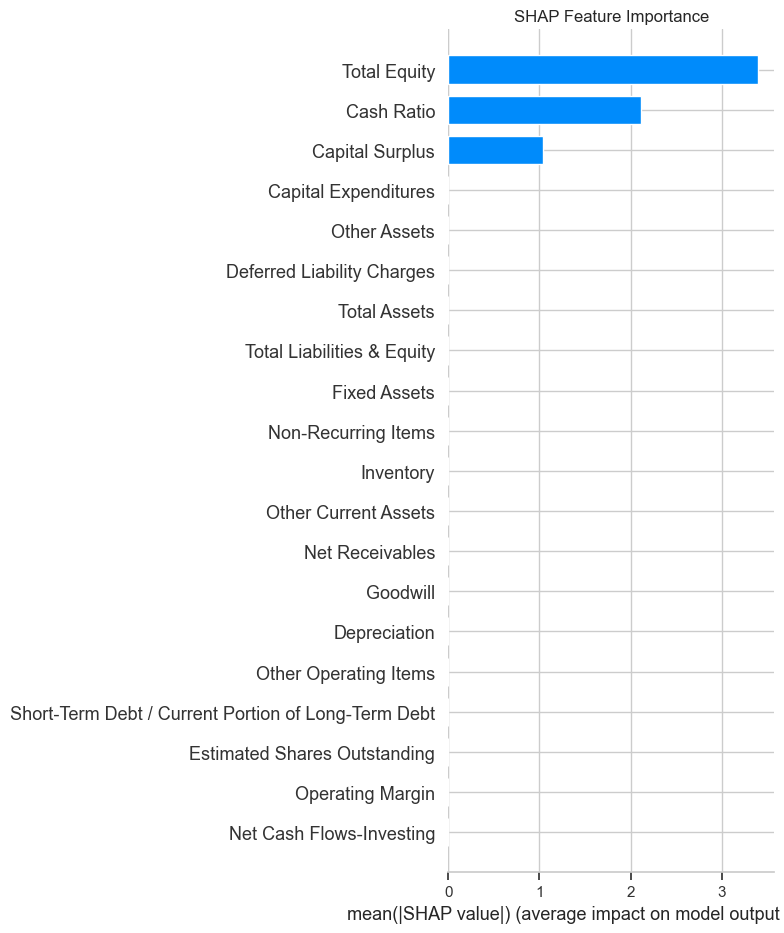

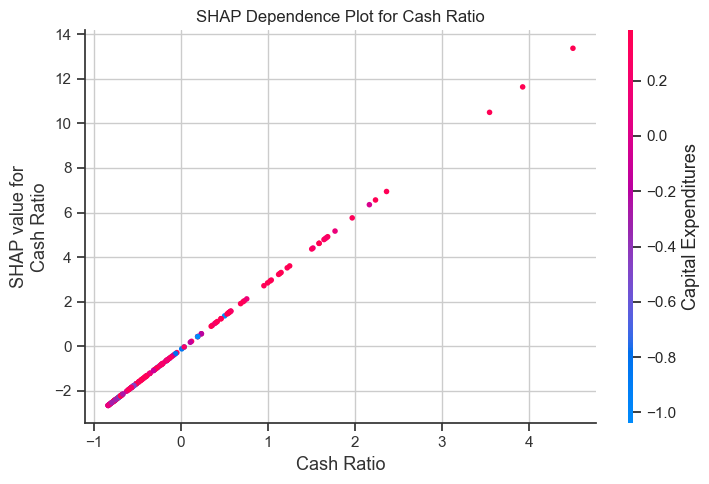

In [60]:
# Select the best model based on R2 score
best_model_name = evaluation_metrics.sort_values(by='R2', ascending=False).iloc[0]['Model']
best_model = best_models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# Initialize SHAP explainer
explainer = shap.Explainer(best_model, X_test_filtered)
shap_values = explainer(X_test_filtered)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_filtered, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# Dependence plot for the top feature
top_feature = selected_features[0]
shap.dependence_plot(top_feature, shap_values.values, X_test_filtered, show=False)
plt.title(f'SHAP Dependence Plot for {top_feature}')
plt.tight_layout()
plt.show()